In [ ]:
# !pip3 install torch torchvision

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, ), (0.5, ))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [5]:
classes = ['apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 
           'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 
           'chimpanzee', 'clock', 'cloud', 'cockroach', 'computer keyboard', 'couch', 'crab', 'crocodile', 
           'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
           'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle', 
           'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck', 
           'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
           'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
           'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
           'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow', 'wolf', 'woman', 'worm']

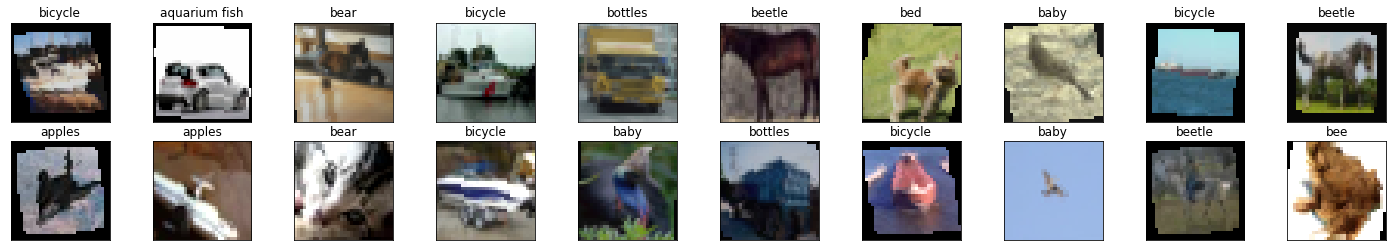

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [8]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1) # higer kernel, more parameters, overfiting
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1) # when add layers, how the layers are connected and channel values are related
    self.fc1 = nn.Linear(4*4*64, 500) # how to determine the value of 4*4 or 5*5
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x): # be careful the capitalizaiton of x and layers of LeNet
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2) # what does pool2d mean? 2?
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) 
      x = self.fc2(x)
      return x

In [9]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [11]:
epochs = 30
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 1.7047, acc37.3860
validation loss: 1.4132, validation acc48.3400
epoch: 2
training loss: 1.3935, acc49.5620
validation loss: 1.2396, validation acc55.9500
epoch: 3
training loss: 1.2677, acc54.7120
validation loss: 1.1269, validation acc59.8300
epoch: 4
training loss: 1.1826, acc57.6840
validation loss: 1.0625, validation acc62.1500
epoch: 5
training loss: 1.1112, acc60.5100
validation loss: 1.0234, validation acc64.7800
epoch: 6
training loss: 1.0608, acc62.4600
validation loss: 0.9537, validation acc66.7300
epoch: 7
training loss: 1.0229, acc64.1240
validation loss: 0.9392, validation acc67.2800
epoch: 8
training loss: 0.9889, acc65.2080
validation loss: 0.9058, validation acc68.2400
epoch: 9
training loss: 0.9580, acc66.5040
validation loss: 0.9052, validation acc68.6800
epoch: 10
training loss: 0.9346, acc67.0260
validation loss: 0.8440, validation acc70.7400
epoch: 11
training loss: 0.9157, acc67.8100
validation loss: 0.8381, validation acc71.4000
epoch: 1

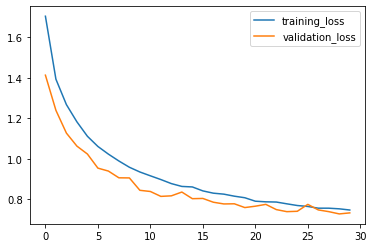

In [12]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(val_running_loss_history, label = "validation_loss")
plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

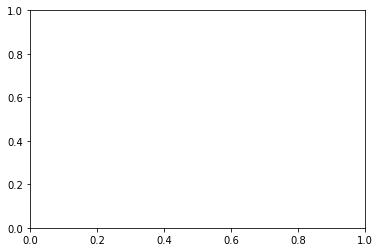

In [13]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(val_running_corrects_history, label = "validation_accuracy")
plt.legend()

In [14]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2
    Running setup.py install for pillow ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.5.0 requires pillow>=6.2.0, but you have pillow 5.2.0 which is incompatible.
imageio 2.11.1 requires pillow>=8.3.2, but you have pillow 5.2.0 which is incompatible.


In [15]:
import PIL.ImageOps

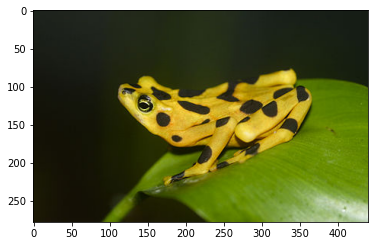

In [16]:
import requests
from PIL import Image

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Atelopus_zeteki1.jpg/440px-Atelopus_zeteki1.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

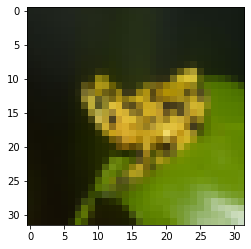

In [17]:
img = transform(img)
plt.imshow(im_convert(img))

In [18]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


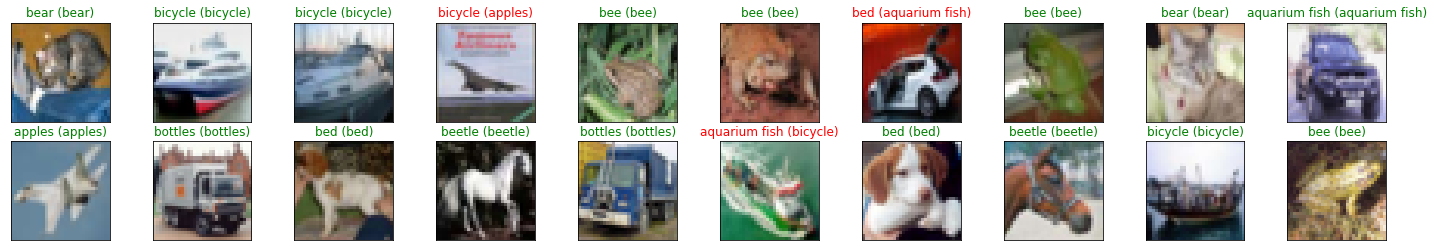

In [19]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
lables = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))